# 1. Import Dependencies

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 2. Define constants

In [3]:
IMG_HEIGHT = 120
IMG_WIDTH = 120
COLOR_CHANNELS = 3  # For grayscale images

# 3. Load and Visualize the Dataset

## 3.1 Helper Functions to load, preprocess and visualise images

In [4]:
# Function to get Random Indices 
def get_random_indices(images, n):
    return np.random.choice(images.shape[0], n, replace=False)

In [5]:
# Loads Images fron the given filepath
load_resolution = (200, 200) # Width x Height

def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        # Read the image
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is not None:
            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize each image to a smaller size that is easier to work with
            image = cv2.resize(image, (200, 200))
            
            images.append(image)
    return np.array(images)

In [6]:
# Preprocess images (resize, normalize)
def preprocess_images(images, noise_factor=0.1):
    noisy = []  # noisy images
    original = []  # original images
    for img in images:
        # Resize images to desired input and output sizes
        input_image = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        
        # Normalize pixel values to [0, 1]
        input_image = input_image / 255.0

        # Add noise to input images to create noisy images
        noise = np.random.normal(loc=0.0, scale=noise_factor, size=input_image.shape)
        noisy_image = input_image + noise
        noisy_image = np.clip(noisy_image, 0.0, 1.0)  # Ensure values are within [0, 1]

        # Append to respective lists
        noisy.append(noisy_image)
        original.append(input_image)

    # Reshape to match input dimensions (batch, height, width, channels)
    noisy = np.array(noisy).reshape(-1, IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS)
    original = np.array(original).reshape(-1, IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS)
    return original, noisy

In [7]:
# Define the function to display the images in a single plot grid
def visualize(images, label, indices):  
    plt.figure(figsize=(15, 5))
    n = len(indices)

    if len(images) != 0:
        for i, idx in enumerate(indices):
            plt.subplot(3, n, i + 1)
            plt.imshow(images[idx])
            plt.axis('off')
    # Add a single title above the subplots with reduced padding
    plt.suptitle(label, y=0.95)  # Adjust the y value to reduce padding below the title
    plt.show()

## 3.2 Load the Dataset

In [8]:
images = load_images('dataset/')

## 3.3 Preprocess Images

In [9]:
original, noisy  = preprocess_images(images, noise_factor=0.3)

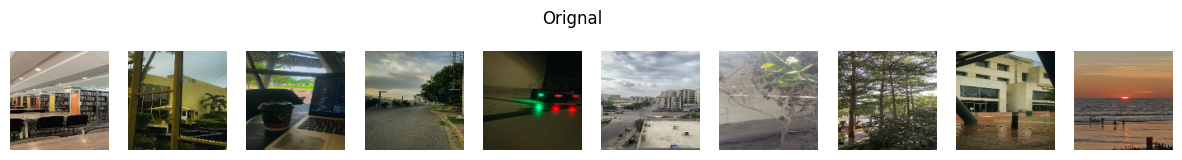

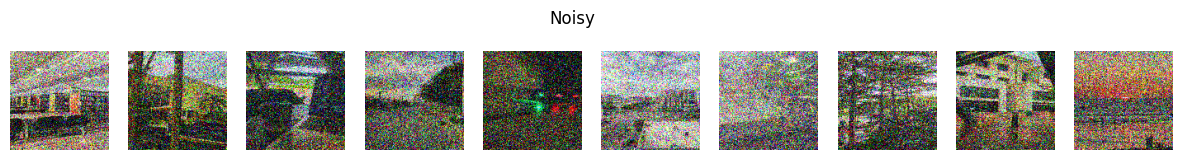

In [10]:
indices = get_random_indices(original, 10)

visualize(original, 'Orignal', indices)
visualize(noisy, 'Noisy', indices)

## 3.4 Prepare the testing and training set

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(noisy, original, test_size=0.2, random_state=42)

# 4. Define and Compile the model

## 4.1 Define the Model

In [88]:
def get_denoiser():
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS)))

    # Hidden layers
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Conv2D(COLOR_CHANNELS, (3, 3), padding='same'))
    model.add(Activation('sigmoid'))  # Use sigmoid for normalized pixel values in [0, 1]

    return model


## 4.2 Initialize the model

In [89]:
model = get_denoiser()
model.compile(optimizer=Adam(), loss='mse')

# 5. Train the model

In [90]:
history = model.fit(X_train,Y_train, epochs=10, batch_size=16, validation_data=(X_test, Y_test))

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0355 - val_loss: 0.0574
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0102 - val_loss: 0.0574
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0083 - val_loss: 0.0459
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0073 - val_loss: 0.0399
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0065 - val_loss: 0.0297
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0063 - val_loss: 0.0129
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0063 - val_loss: 0.0052


# 6. Plot training History

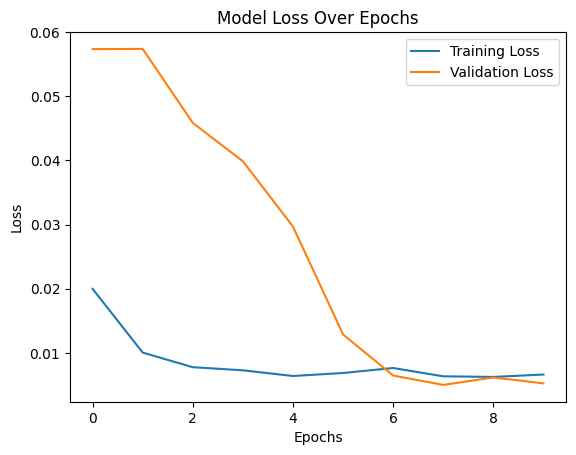

In [91]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7. Test and Evaluate Model Performance

## 7.1 Evaluate the model

In [92]:
test_loss = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0053
Test Loss: 0.005235705524682999


## 7.2 Test the model

In [93]:
_ , noisy_new  = preprocess_images(images, noise_factor=0.1)

In [94]:
denoised_images = model.predict(noisy_new)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


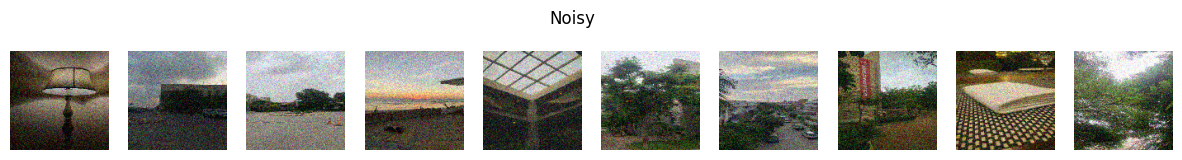

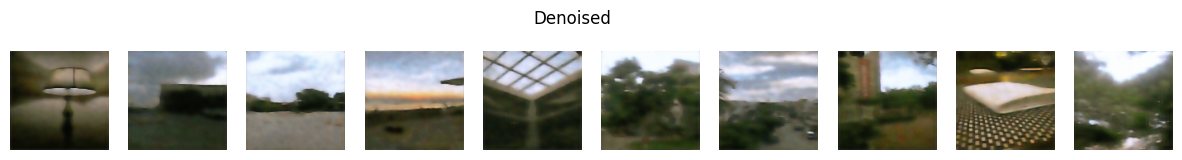

In [101]:
# Call the function with the test data and predictions
indices = get_random_indices(noisy_new, 10)
visualize(noisy_new, 'Noisy', indices)
visualize(denoised_images, 'Denoised', indices)

# 8. Save the model

In [106]:
model.save('denoiser.keras')